<a href="https://colab.research.google.com/github/aubricot/computer_vision_with_eol_images/blob/master/object_detection_for_image_tagging/plant_pollinator/plant_poll_generate_tags_yolov3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using YOLO v3 pre-trained on Google Open Images to add plant-pollinator co-occurrence tags for ladybugs, beetles, and insects in plant images
---
*Last Updated 19 July 2021*   
Using a YOLOv3 model (downloaded from [here](https://github.com/AlexeyAB/darknet) ) pre-trained on [Google Open Images](https://storage.googleapis.com/openimages/web/visualizer/index.html?set=train&type=detection&c=%2Fm%2F03vt0) as a method to do customized, large-scale image processing. EOL Angiosperm images will be tagged for plant-pollinator co-occurrence using the detected insects. Tags will further extend EOLv3 image search functions.

## Installs & Imports
---

In [ ]:
# Optional: Mount google drive to import/export files
# To test with a small subset without connecting to Drive, skip this step and proceed
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
# For importing/exporting files, working with arrays, etc
import os
import glob
import pathlib
import six.moves.urllib as urllib
import sys
import tarfile
import zipfile
import numpy as np 
import csv
import matplotlib.pyplot as plt
import time
import pandas as pd

# For downloading images
!apt-get install aria2

# For drawing onto and plotting images
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import cv2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libc-ares2
The following NEW packages will be installed:
  aria2 libc-ares2
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,274 kB of archives.
After this operation, 4,912 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libc-ares2 amd64 1.14.0-1 [37.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 aria2 amd64 1.33.1-1 [1,236 kB]
Fetched 1,274 kB in 1s (993 kB/s)
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.14.0-1_amd64.deb ...
Unpacking libc-ares2:amd64 (1.14.0-1) ...
Selecting previously unselected package aria2.
Preparing to unpack .../aria2_1.33.1-1_amd64.deb ...
Unpacking aria2 (1.33.1-1) ...
Setting up libc-ares2:a

## Model preparation (only run once)
---

In [ ]:
# Install darknet

# Test pipeline in Colab without connecting to Google Drive?
# TO DO: If yes, check test_without_drive box
test_without_drive = True #@param {type: "boolean"}

# Only if connecting to Google Drive
# TO DO: Type in the path to your working directory in form field to right
basewd = "/content/drive/MyDrive/train" #@param {type:"string"}
if test_without_drive:
    basewd = '/content'
wd = 'darknet'
%cd $basewd

# Download darknet (the native implementation of YOLO)
if os.path.exists(wd):
    %cd $wd

elif not os.path.exists(wd):
    !git clone https://github.com/AlexeyAB/darknet
    # Compile darknet
    %cd $wd
    # Make folders for detection datafiles
    os.makedirs('data/imgs')
    os.makedirs('data/img_info')
    os.makedirs('data/results')
    # Change makefile to have GPU and OPENCV enabled
    !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
    !sed -i 's/GPU=0/GPU=1/' Makefile
    !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
    !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
    # Download pretrained YOLOv3 weights for Open Images
    !wget https://pjreddie.com/media/files/yolov3-openimages.weights

# Verify CUDA version (for using GPU)
!/usr/local/cuda/bin/nvcc --version

# Make darknet
!make

/content
Cloning into 'darknet'...
remote: Enumerating objects: 15283, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 15283 (delta 40), reused 50 (delta 26), pack-reused 15186
Receiving objects: 100% (15283/15283), 13.75 MiB | 19.91 MiB/s, done.
Resolving deltas: 100% (10349/10349), done.
/content/darknet
--2021-07-19 13:20:37--  https://pjreddie.com/media/files/yolov3-openimages.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 259229388 (247M) [application/octet-stream]
Saving to: ‘yolov3-openimages.weights’

yolov3-openimages.w 100%[===================>] 247.22M  74.2MB/s    in 3.3s    

2021-07-19 13:20:41 (74.2 MB/s) - ‘yolov3-openimages.weights’ saved [259229388/259229388]

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22

## Generate cropping coordinates for images
---
Run EOL 20k image bundles through pre-trained object detection models and save results in 4 batches (A-D). 

### Prepare object detection functions and settings

In [ ]:
# Functions

# Read in data file
def read_datafile(fpath, sep="\t", header=0, disp_head=True):
    """
    Defaults to tab-separated data files with header in row 0
    """
    try:
        df = pd.read_csv(fpath, sep=sep, header=header)
        if disp_head:
            print("Data header: \n", df.head())
    except FileNotFoundError as e:
        raise Exception("File not found: Enter the path to your file in form field and re-run").with_traceback(e.__traceback__)
    
    return df

# Read in bundle images
def read_eolbundle(bundle, no_bundles):
    # Get first 20k images for Angiosperm bundles using initial bundle basename
    base = os.path.splitext(os.path.basename(bundle))[0].rsplit('_',1)[0]
    # Load in all sub-bundles (ex: 000001 - 000031 for Angiosperms)
    nums1 = list(range(1, 10))
    nums2 = list(range(10, no_bundles))
    exts1 = ["00000" + str(num) + ".txt" for num in nums1]
    exts2 = ["0000" + str(num) + ".txt" for num in nums2]
    exts = exts1 + exts2
    all_filenames = ["https://editors.eol.org/other_files/bundle_images/files/" + base + "_" + e for e in exts]
    bundles = pd.concat([pd.read_csv(f, sep='\t', header=None) for f in all_filenames], ignore_index=True)
    print("EOL image bundle with {} images: \n{}".format(len(bundles), bundles.head()))
    return bundles

# Define start and stop indices in EOL bundle for running inference   
def set_start_stop():
    # To test with a tiny subset, use 5 random bundle images
    if test_with_tiny_subset:
        start=np.random.choice(a=1000, size=1)[0]
        stop=start+5
    # To run inference on 4 batches of 5k images each
    elif "_a." in outfpath: # batch a is from 0-5000
        start=0
        stop=5000
    elif "_b." in outfpath: # batch b is from 5000-1000
        start=5000
        stop=10000
    elif "_c." in outfpath: # batch c is from 10000-15000
        start=10000
        stop=15000
    elif "_d." in outfpath: # batch d is from 15000-20000
        start=15000
        stop=20000
    
    return start, stop

# To display results
def imShow(path):
    image = cv2.imread(path)
    height, width = image.shape[:2]
    resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

    fig = plt.gcf()
    fig.set_size_inches(18, 10)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    plt.show()

# For uploading an image from url
# Modified from https://www.pyimagesearch.com/2015/03/02/convert-url-to-image-with-python-and-opencv/
def url_to_image(url):
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    im_h, im_w = image.shape[:2]
 
    return image

### Temporarily download images from EOL bundle to Google Drive (YOLO cannot directly parse URL images)

In [ ]:
# Download images for 20K bundle of Angiosperm images with 31 sub-bundles
# To DO: Enter any EOL Angiosperm image bundle URL
bundle = "https://editors.eol.org/other_files/bundle_images/files/images_for_Angiosperms_20K_breakdown_download_000030.txt" #@param {type:"string"}
df = read_eolbundle(bundle, 31)

# Test with a smaller subset than 5k images?
# TO DO: If yes, check test_with_tiny_subset box
test_with_tiny_subset = True #@param {type: "boolean"}

# Take 5k subset of bundle for running inference
# TO DO: Change file name for each bundle/run abcd if doing 4 batches using dropdown form to right
subset = "plant_poll_coocc_tags_a" #@param ["plant_poll_coocc_tags_a", "plant_poll_coocc_tags_b", "plant_poll_coocc_tags_c", "plant_poll_coocc_tags_d"] {allow-input: true}
subset = subset + ".txt"
outfpath = "data/imgs/" + subset

# Save 5k subset to text file for image download
start, stop = set_start_stop()
df = df.iloc[start:stop]
df.to_csv(outfpath, sep='\n', index=False, header=False)

# Download images 
# Note: Takes 7-10 min per 5k imgs, aria2 downloads 16imgs at a time
img_outfpath = "data/imgs"
%cd $img_outfpath
!aria2c -x 16 -s 1 -i $subset

# Verify how many images downloaded
print("Number of images downloaded to Google Drive: ")
!ls . | wc -l

EOL image bundle with 600000 images: 
                                                   0
0  https://content.eol.org/data/media/9d/c5/89/85...
1  https://content.eol.org/data/media/9d/c8/c4/85...
2  https://content.eol.org/data/media/9d/cc/ac/85...
3  https://content.eol.org/data/media/9d/d0/94/85...
4  https://content.eol.org/data/media/9d/d4/7c/85...
/content/darknet/data/imgs

07/19 13:32:14 [NOTICE] Downloading 5 item(s)

07/19 13:32:15 [NOTICE] Download complete: /content/darknet/data/imgs/913.31669.jpg

07/19 13:32:15 [NOTICE] Download complete: /content/darknet/data/imgs/913.48008.jpg

07/19 13:32:15 [NOTICE] Download complete: /content/darknet/data/imgs/913.121903.jpg

07/19 13:32:15 [NOTICE] Download complete: /content/darknet/data/imgs/913.90688.jpg

07/19 13:32:15 [NOTICE] Download complete: /content/darknet/data/imgs/913.128532.jpg

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
1620a9|OK  

In [ ]:
# If images downloaded correctly, move text file to data/img_info/
%cd ../
!mv imgs/*.txt img_info/
%cd ../

/content/darknet/data


In [ ]:
# Make imgs.txt file to run images through YOLO for inference in batches by filename
%cd darknet

inf_subset = img_outfpath + '/' + subset
with open(inf_subset, 'w', encoding='utf-8') as f:
    for dir, dirs, files in os.walk(img_outfpath):
        files = [fn for fn in files]
        for fn in files:
            if 'txt' not in fn:
                out = "data/imgs/" + fn
                f.writelines(out + '\n')

# Inspect imgs.txt file to confirm length and content
print("\nNumber of images in {}: {}".format(inf_subset, len(df)))
df = read_datafile(inf_subset, header=None, sep='\n', disp_head=True)

/content/darknet

Number of images in data/imgs/plant_poll_coocc_tags_a.txt: 5

Images textfile: 

Data header: 
                           0
0   data/imgs/913.48008.jpg
1  data/imgs/913.121903.jpg
2   data/imgs/913.90688.jpg
3   data/imgs/913.31669.jpg
4  data/imgs/913.128532.jpg


### Run images through trained model
---

#### Test: Run individual image through by filename and display results

/content/darknet/data/imgs
Downloading...
From: https://drive.google.com/uc?id=1WVafbU3htUUiSo-Qvs3sA1Y0Medz4o7D
To: /content/darknet/data/imgs/542.6248219776.jpg
2.66MB [00:00, 133MB/s]
/content/darknet
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   3 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   5 conv    128       3 x 3/ 2 

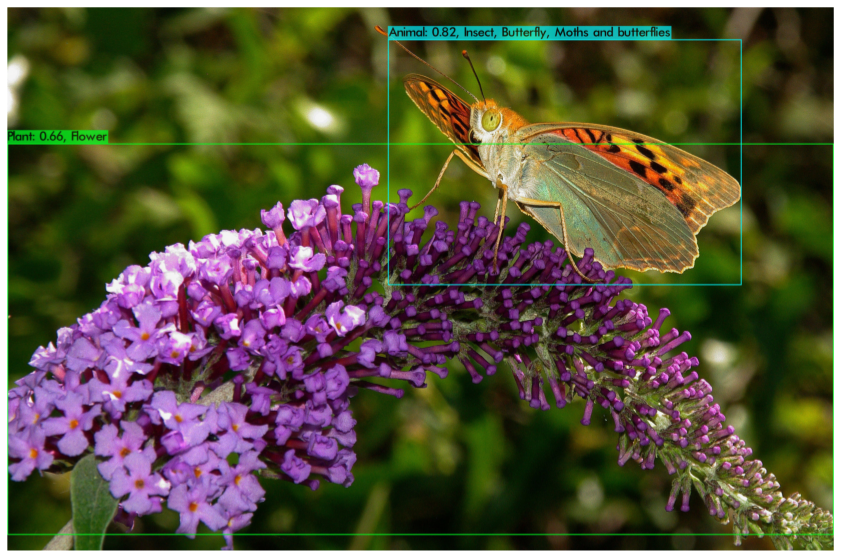

In [ ]:
# Run inference on a single image by filename and show results
# TO DO: First, run with sample EOL 'butterfly bush' image
# To test with your own image, upload file to data/imgs and update fn formfield

# First, download sample EOL 'butterfly bush' image 
%cd data/imgs
!gdown --id 1WVafbU3htUUiSo-Qvs3sA1Y0Medz4o7D
%cd ../..

# TO DO: Put image in data/imgs & enter filename in formfield
fn = "542.6248219776.jpg" #@param {type:"string"}
img_fpath = 'data/imgs/' + fn

# Run darknet and show bounding box coordinates
!./darknet detector test cfg/openimages.data cfg/yolov3-openimages.cfg yolov3-openimages.weights {img_fpath}

# Display detection results
imShow('predictions.jpg')

### Generate crops: Run inference on EOL images & save results for cropping
Use 20K EOL Angiosperm image bundles to get bounding boxes of detected pollinators. Results are saved to [crops_file].tsv.   
Run in 4 batches of 5K images to backup regularly in case of Colab timeouts.

In [ ]:
# Run inference on 5k image subset using darknet

# Run darknet with flag to not show bounding box coordinates
!./darknet detector test cfg/openimages.data cfg/yolov3-openimages.cfg yolov3-openimages.weights -dont_show -save_labels < {outfpath}

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 1, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   3 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   5 conv    128       3 x 3/ 2    304 x 304 x  64 ->  152 x 152 x 128 3.407 BF
   6 conv     64       1 x 1/ 1    152 x 152 x 128 ->  152 x 152 x  64 0.379 BF
   7 conv    128       3 x 3/ 1    152 x 152 x  64 ->  152 x 152 x 128 3.407

## Post-process detection results
--- 
Combine output files for batches A-D. Then, convert detection boxes into plant-pollinator co-occurrence tags.

In [ ]:
# Combine individual prediction files for each image to all_predictions.txt

# Delete image file list for inference
!rm $outfpath

# Combine individual text files and image filenames into all_predictions.txt
fns = os.listdir('data/imgs')
with open('data/results/all_predictions.txt', 'w') as outfile:
  header = "class_id x y w h img_id"
  outfile.write(header + "\n")
  for fn in fns:
        if 'txt' in fn:
          with open('data/imgs/'+fn) as infile:
            lines = infile.readlines()
            newlines = [''.join([x.strip(), ' ' + os.path.splitext(fn)[0] + '\n']) for x in lines]
            outfile.writelines(newlines)

# Inspect saved predictions
df = pd.read_csv('data/results/all_predictions.txt')
print("Model predictions: \n", df.head())

# Delete all individual prediction files
!rm -r data/imgs/*.txt

# Delete all image files now that they have been used for inference
!rm -r data/imgs/*

Model predictions: 
                       class_id x y w h img_id
0   333 0.5435 0.4978 0.9164 0.9893 913.48008
1  333 0.5006 0.5473 0.9654 0.8721 913.121903
2  333 0.5023 0.4996 1.0364 1.0349 913.128532
3   333 0.4056 0.2234 0.5505 0.2207 913.31669


In [ ]:
map_urls.set_index('img_id', inplace=True, drop=True)

print(tag_df)
print(map_urls)

           class_id       x       y       w       h
img_id                                             
913.480080    Plant  0.5435  0.4978  0.9164  0.9893
913.121903    Plant  0.5006  0.5473  0.9654  0.8721
913.128532    Plant  0.5023  0.4996  1.0364  1.0349
913.316690    Plant  0.4056  0.2234  0.5505  0.2207
                                                            url
img_id                                                         
509.32946653  https://content.eol.org/data/media/5e/d9/16/50...
509.32946654  https://content.eol.org/data/media/5e/d9/17/50...
509.32946657  https://content.eol.org/data/media/5e/d9/18/50...
509.32946659  https://content.eol.org/data/media/5e/d9/19/50...
509.33211309  https://content.eol.org/data/media/5e/e4/6e/50...
...                                                         ...
509.19100828  https://content.eol.org/data/media/5c/1a/8b/50...
509.44588401  https://content.eol.org/data/media/61/88/c9/50...
509.61107823  https://content.eol.org/data/media

In [ ]:
mapped_tagdf = tag_df.merge(map_urls, left_index=True, right_index=True)
print(mapped_tagdf)
mapped_tagdf.reset_index(drop=False, inplace=True)
mapped_tagdf.drop_duplicates(inplace=True, ignore_index=True)
print("\nModel predictions with EOL media URL's: \n", mapped_tagdf.head())

Empty DataFrame
Columns: [class_id, x, y, w, h, url]
Index: []

Model predictions with EOL media URL's: 
 Empty DataFrame
Columns: [img_id, class_id, x, y, w, h, url]
Index: []


In [ ]:
# Create final predictions dataframe with class names (instead of numbers) and image urls
# EOL 20k image url bundle
df = pd.read_csv(bundle)
df.columns = ['url']
print("EOL media URL's corresponding to inference images: \n", df)

# Model predictions with number-coded classes
predict = pd.read_csv('data/results/all_predictions.txt', header=0, sep=" ")
predict.class_id = predict.class_id - 1 #class_id counts started from 1 instead of 0 from YOLO
print("\nModel predictions by class id: \n", predict)

# Add class names to model predictions
classnames = pd.read_table('data/openimages.names')
classnames.columns = ['classname']
#print("Verifying class names: \n", classnames)
tag_df = predict.copy()
di = pd.Series(classnames.classname.values,index=classnames.index).to_dict()
tag_df.replace({"class_id":di}, inplace=True)
tag_df['class_id'] = tag_df['class_id'].astype(str)
print("\nModel prediction classes translated from class id's: \n", tag_df)

# Add EOL media URL's to model predictions
map_urls = df.copy()
img_ids = map_urls['url'].apply(lambda x: os.path.splitext((os.path.basename(x)))[0])
map_urls['img_id'] = img_ids
tag_df.set_index('img_id', inplace=True, drop=True)
map_urls.set_index('img_id', inplace=True, drop=True)
mapped_tagdf = tag_df.merge(map_urls, left_index=True, right_index=True)
mapped_tagdf.reset_index(drop=False, inplace=True)
mapped_tagdf.drop_duplicates(inplace=True, ignore_index=True)
print("\nModel predictions with EOL media URL's: \n", mapped_tagdf.head())

# Save final tags to file
fn = os.path.splitext(subset)[0]
outpath = 'data/results/' + fn + '.tsv'
mapped_tagdf.to_csv(outpath, sep="\t", index=False)

EOL media URL's corresponding to inference images: 
                                                      url
0      https://content.eol.org/data/media/5e/d9/16/50...
1      https://content.eol.org/data/media/5e/d9/17/50...
2      https://content.eol.org/data/media/5e/d9/18/50...
3      https://content.eol.org/data/media/5e/d9/19/50...
4      https://content.eol.org/data/media/5e/e4/6e/50...
...                                                  ...
19994  https://content.eol.org/data/media/5c/1a/8b/50...
19995  https://content.eol.org/data/media/61/88/c9/50...
19996  https://content.eol.org/data/media/65/c3/c4/50...
19997  https://content.eol.org/data/media/68/21/d6/50...
19998  https://content.eol.org/data/media/65/2b/2f/50...

[19999 rows x 1 columns]

Model predictions by class id: 
    class_id       x       y       w       h      img_id
0       332  0.5435  0.4978  0.9164  0.9893  913.480080
1       332  0.5006  0.5473  0.9654  0.8721  913.121903
2       332  0.5023  0.4996  1.0364

#### Merge batch output files A-D

In [ ]:
# Write header row of output tagging file
# TO DO: Enter any filename from 4 batches of tagging files
tags_file = "plant_poll_coocc_tags_d" #@param {type:"string"}
tags_fpath = "data/results/" + tags_file + ".tsv"

# Combine exported model predictions and confidence values for all batches
fpath =  os.path.splitext(tags_fpath)[0]
base = fpath.rsplit('_',1)[0] + '_'
exts = ['a.tsv', 'b.tsv', 'c.tsv', 'd.tsv'] 
all_filenames = [base + e for e in exts]
df1 = pd.concat([pd.read_csv(f, sep='\t', header=0, na_filter = False) for f in all_filenames], ignore_index=True)

# Filter for desired classes
# TO DO: Enter a list of pollinator classes to filter by
filter = ['Butterfly', 'Insect', 'Beetle', 'Ant', 'Bat (Animal)', 'Bird', 'Bee', 'Invertebrate', 'Animal'] #@param
pattern = '|'.join(filter)
df = df1.copy()
df.loc[df['class_id'].str.contains(pattern), 'class_id'] = 'Pollinator'
print("No. tags matching filtered classes: \n", len(df.class_id[df.class_id.str.contains(pattern)]))
print("\nTags matching filtered classes: \n", df.class_id[df.class_id.str.contains(pattern)])
df.loc[~df.class_id.str.contains(pattern), 'class_id'] = 'None'
print("\nNo. not tags matching filtered classes: \n", len(df.class_id[~df.class_id.str.contains(pattern)]))
print("\nTags not matching filtered classes: \n", df[~df.class_id.str.contains(pattern)])

# Write results to tsv
outfpath = base + 'finaltags.tsv'
df.to_csv(outfpath, sep='\t', index=False)
print("\n\nFinal output tagging file {}: \n{}".format(outfpath, df.head()))

## Display cropping results on images
---

In [ ]:
# TO DO: Do you want to use the tagging file exported above?
use_outfpath = "no" #@param ["yes", "no"]
# If no, choose other path to use
otherpath = "data/results/plant_poll_coocc_tags_finaltags.tsv" #@param {type:"string"}
if use_outfpath == "yes":
  outfpath = outfpath
else:
  outfpath = otherpath
df = pd.read_csv(outfpath, sep="\t", header=0)
print("File for tag export {}: \n{}".format(outfpath, df.head()))

In [ ]:
# Display tags on images

# TO DO: Adjust line below to see up to 50 images displayed at a time
start = 0 #@param {type:"slider", min:0, max:5000, step:50}
stop = start+50

# Loop through images
for i, row in df.iloc[start:stop].iterrows():
    # Read in image 
    url = df['eolMediaURL'][i]
    img = url_to_image(url)

    # Fetch image tag
    tag = df['class_id'][i]
  
    # Plot cropping box on image
    _, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img)

    # Display image URL and coordinatesabove image
    # Helps with fine-tuning data transforms in post-processing steps above
    plt.title('{}) {} \n Tag: {}'.format(i+1, url, tag))